# 本地ONNX Runtime部署-摄像头单帧图像预测

同济子豪兄 2023-8-19 2023-9-1 2023-9-2

## 导入工具包

In [1]:
import time
import numpy as np
import cv2
from cvs import *

import onnxruntime
import torch

import matplotlib.pyplot as plt
%matplotlib inline

## 载入 ONNX 模型，获取 ONNX Runtime 推理器

In [2]:
# ONNX 模型路径
onnx_path = 'mmseg2onnx_fastscnn/end2end.onnx'

In [2]:
# ONNX 模型路径
onnx_path = 'mmseg2onnx_fastscnn_static/end2end.onnx'

In [3]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

/usr/local/lib/python3.7/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))


## 可视化配置

In [4]:
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [5]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 初始化摄像头

In [6]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [7]:
cap = cvs.VideoCapture(Camera_ID)

remi.server      INFO     Started httpserver http://0.0.0.0:40011/


('app runs on port:', 40011)
open the cam:0 ...


remi.request     INFO     built UI (path=/)
remi.server.ws   INFO     connection established: ('192.168.1.5', 52702)
remi.server.ws   INFO     handshake complete
remi.server.ws   INFO     connection established: ('192.168.1.5', 52705)
remi.server.ws   INFO     handshake complete
remi.server.ws   INFO     connection established: ('127.0.0.1', 34578)
remi.server.ws   INFO     handshake complete
remi.server.ws   ERROR    Error managing incoming websocket message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 166, in read_next_message
    length = self.bytetonum(length[1]) & 127
IndexError: index out of range
remi.request     ERROR    sending websocket spontaneous message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 497, in _send_spontaneous_websocket_message
    if ws.send_message(message):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_mes

## 调用摄像头获取一帧画面

In [8]:
img_bgr = cap.read()

In [9]:
img_bgr.shape

(640, 480, 3)

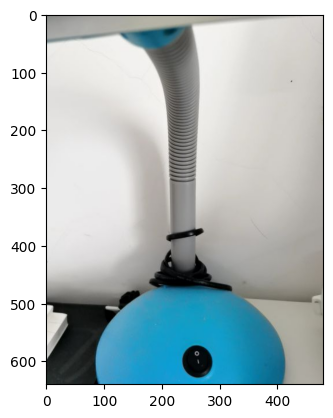

In [10]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 将手机拍摄到的竖屏图像旋转90度，变成横屏图像

In [11]:
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE)

In [12]:
img_bgr.shape

(480, 640, 3)

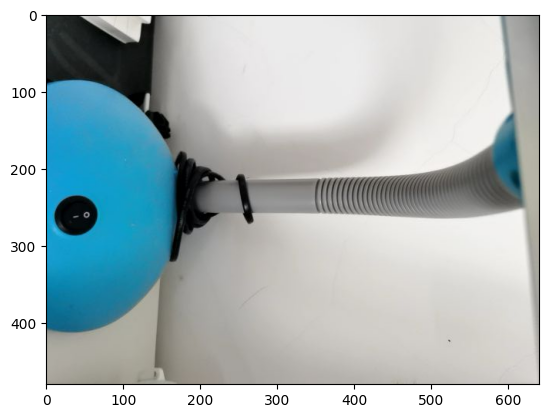

In [13]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 从原图中裁剪出高宽比1:2的最大图像

In [14]:
h, w = img_bgr.shape[0], img_bgr.shape[1]
new_h = w // 2 # 横屏图片，截取一半的宽度，作为新的高度
img_bgr_crop = img_bgr[0:new_h, :]

In [15]:
img_bgr_crop.shape

(320, 640, 3)

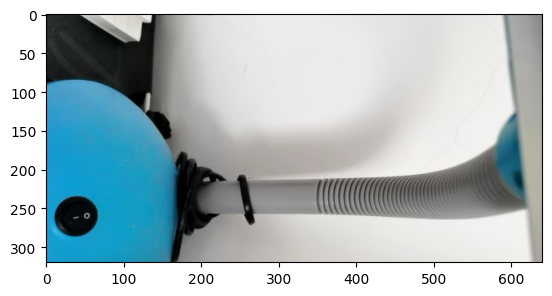

In [16]:
plt.imshow(img_bgr_crop[:,:,::-1])

## 缩放至模型要求的高1024 x 宽2048像素

In [17]:
img_bgr_resize = cv2.resize(img_bgr_crop, (2048, 1024)) # 缩放尺寸

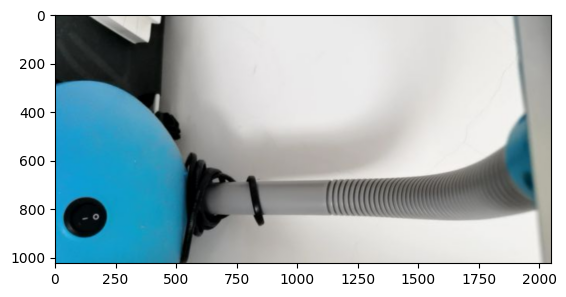

In [18]:
plt.imshow(img_bgr_resize[:,:,::-1])

## 预处理

In [19]:
# 预处理
img_tensor = img_bgr_resize
mean = (123.675, 116.28, 103.53) # BGR 三通道的均值
std = (58.395, 57.12, 57.375) # BGR 三通道的标准差

# 归一化
img_tensor = (img_tensor - mean) / std
img_tensor = img_tensor.astype('float32')
img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2RGB) # BGR 转 RGB
img_tensor = np.transpose(img_tensor, (2, 0, 1)) # 调整维度
input_tensor = np.expand_dims(img_tensor, axis=0) # 扩充 batch-size 维度

In [20]:
input_tensor.shape

(1, 3, 1024, 2048)

## ONNX Runtime预测

In [21]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]
pred_mask = ort_output[0][0]

In [22]:
pred_mask.shape

(1024, 2048)

## 将预测的整数ID，映射为对应类别的颜色

In [23]:
opacity = 0.3 # 透明度，越大越接近原图

pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)

In [24]:
pred_viz.shape

(1024, 2048, 3)

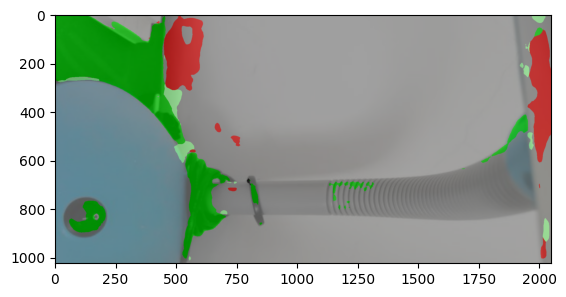

In [25]:
plt.imshow(pred_viz[:,:,::-1])
plt.show()

## 后处理，便于在手机屏幕上显示

In [26]:
img_bgr = pred_viz

In [27]:
img_bgr = cv2.resize(img_bgr, (640, 320)) # 缩放尺寸

In [28]:
img_bgr.shape

(320, 640, 3)

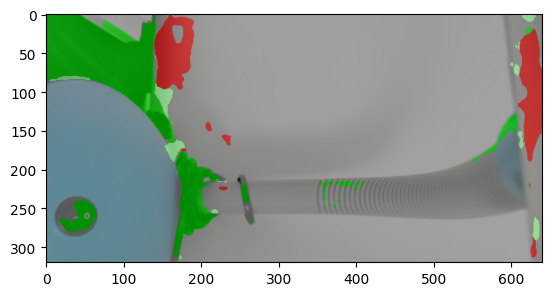

In [29]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [30]:
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE)

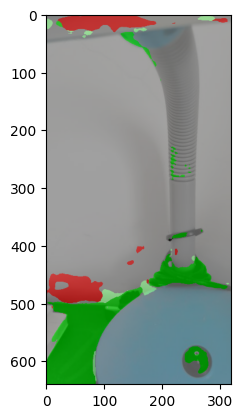

In [31]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 在手机屏幕上显示

In [32]:
cvs.imshow(img_bgr)